In [1]:
import os;
os.environ['KMP_DUPLICATE_LIB_OK']='True';

In [2]:
import tensorflow as tf;
import numpy as np;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;

In [3]:
class TensorProjectionLayer(tf.keras.layers.Layer):
    def __init__(self, q1,q2,q3, regularization=False, rate=10**-3,**kwargs):
        self.q1 = int(q1);
        self.q2 = int(q2);
        self.q3 = int(q3);
        self.e1 = 10**-6;
        self.e2 = 10**-6;
        self.e3 = 10**-6;
        self.regularization = regularization; # regularizer
        self.rate = rate; # regularization coefficient
        super(TensorProjectionLayer, self).__init__(**kwargs);
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.q1, self.q2, self.q3);
    
    
    def build(self, input_shape):
        self.p1 = int(input_shape[1]);
        self.p2 = int(input_shape[2]);
        self.p3 = int(input_shape[3]);
        
        if(self.q1 < self.p1):
            self.W1 = self.add_weight("W1",shape=(self.p1, self.q1),initializer='normal', trainable=True);
        if(self.q2 < self.p2):
            self.W2 = self.add_weight("W2",shape=(self.p2, self.q2),initializer='normal', trainable=True);
        if(self.q3 < self.p3):
            self.W3 = self.add_weight("W3",shape=(self.p3, self.q3),initializer='normal', trainable=True);
            
        super(TensorProjectionLayer, self).build(input_shape);

    # suppose that T: n x t1 x t2 x t3
    # k=1,2,3
    def kmode_product(self, T, A, k):

        # number of the observations
        n  = tf.shape(T)[0];
        t1 = tf.shape(T)[1];
        t2 = tf.shape(T)[2];
        t3 = tf.shape(T)[3];
        uk = tf.shape(A)[0];
        
        # Compute the size of the output-tensor
        if k == 1:
            new_shape = [n, uk, t2, t3];
        elif k == 2:
            new_shape = [n, t1, uk, t3];
        elif k == 3:
            new_shape = [n, t1, t2, uk];
        
        # Compute T xk A
        A = tf.expand_dims(A, 0);
        An =  tf.tile(A, [n, 1, 1]);
        Tk = self.unfold(T,k);
        ATk = tf.linalg.matmul(An, Tk);
        TxkA = self.fold(ATk, k, new_shape);
        return TxkA;
    
    def fold(self, Tk, k, new_shape):
        
        # this is Tensorly-version
        
        a = new_shape;
        
        if k == 1:
            reshape_order =  [0,1,2,3];
            permute_order = [0,1,2,3];
        elif k ==2:
            reshape_order =  [0,2,1,3];
            permute_order = [0,2,1,3];
        elif k == 3:
            reshape_order =  [0,3,1,2];
            permute_order = [0,2,3,1];
        
        new_shape = [a[reshape_order[0]], a[reshape_order[1]], a[reshape_order[2]], a[reshape_order[3]]];
        
        T_ = tf.reshape(Tk, new_shape);
        T = tf.transpose(T_, perm=permute_order);
        return T;
  
    def unfold(self, T, k):
        n  =  tf.shape(T)[0];
        t1 = tf.shape(T)[1];
        t2 = tf.shape(T)[2];
        t3 = tf.shape(T)[3];
        
        if k == 1:
            new_shape = [n, t1,t2*t3];
            A = T;
        elif k ==2:
            new_shape = [n, t2,t3*t1];
            A = tf.transpose(T, perm=[0,2,1,3]);
        elif k ==3:
            new_shape = [n, t3,t1*t2];
            A = tf.transpose(T, perm=[0,3,1,2]);
        
        Tk = tf.reshape(A,new_shape);
        
        return Tk;

    def call(self, X):
        n = tf.shape(X)[0];
        
        if self.q1 < self.p1:
            Iq1 = tf.eye(self.q1);
            W1T = tf.transpose(self.W1, perm=[1,0]);
            M1 = tf.math.add(tf.linalg.matmul(W1T,self.W1), Iq1 * self.e1);
            sqrtM1 = tf.linalg.sqrtm(M1);
            G1 = tf.linalg.inv(sqrtM1);
            U1 = tf.linalg.matmul(self.W1, G1); # p1 x q1
            U1T = tf.transpose(U1, perm=[1,0]); # q1 x p1
        
        if self.q2 < self.p2:
            Iq2 = tf.eye(self.q2);
            W2T = tf.transpose(self.W2, perm=[1,0]);
            M2 = tf.math.add(tf.linalg.matmul(W2T,self.W2), Iq2 * self.e2);
            sqrtM2 = tf.linalg.sqrtm(M2);
            G2 = tf.linalg.inv(sqrtM2);
            U2 = tf.linalg.matmul(self.W2, G2); # p2 x q2
            U2T = tf.transpose(U2, perm=[1,0]); # q2 x p2
            
        if self.q3 < self.p3:
            Iq3 = tf.eye(self.q3);
            W3T = tf.transpose(self.W3, perm=[1,0]);
            M3 = tf.math.add(tf.linalg.matmul(W3T,self.W3), Iq3 * self.e3);
            sqrtM3 = tf.linalg.sqrtm(M3);
            G3 = tf.linalg.inv(sqrtM3);
            U3 = tf.linalg.matmul(self.W3, G3); # p3 x q3
            U3T = tf.transpose(U3, perm=[1,0]); # q3 x p3

    
        Z = X;
        
        if self.q1 < self.p1:
            Z = self.kmode_product(Z, U1T, 1);
        if self.q2 < self.p2:
            Z = self.kmode_product(Z, U2T, 2);
        if self.q3 < self.p3:
            Z = self.kmode_product(Z, U3T, 3);
            
        # This is necessary. But I don't know why...
        Z = tf.reshape(Z, [n,self.q1,self.q2,self.q3]);
        
        # compute reconstruction error
        if self.regularization == True:
            X_ = Z;
            if self.q1 < self.p1:
                X_ = self.kmode_product(X_, U1, 1);
            if self.q2 < self.p2:
                X_ = self.kmode_product(X_, U2, 2);
            if self.q3 < self.p3:
                X_ = self.kmode_product(X_, U3, 3);
            #X_ = tf.reshape(X_, [n,self.p1, self.p2, self.p3]);
            dn2 = tf.math.reduce_mean(tf.math.squared_difference(X , X_),axis=0, keepdims=True);
            dn = tf.math.pow(dn2, 0.5);
            self.add_loss(self.rate *tf.math.reduce_mean(dn), True);
        return Z;

In [4]:
batch_size = 100;
num_classes = 10;
epochs = 10;
# prepare data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data();

img_rows, img_cols = 28, 28

#
if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols);
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols);
    input_shape = (1, img_rows, img_cols);
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1);
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1);
    input_shape = (img_rows, img_cols, 1);

x_train = x_train.astype('float32');
x_test = x_test.astype('float32');
x_train /= 255;
x_test /= 255;
print(x_train.shape[0], 'train samples');
print(x_test.shape[0], 'test samples');
y_train = tf.keras.utils.to_categorical(y_train, num_classes);
y_test = tf.keras.utils.to_categorical(y_test, num_classes);

60000 train samples
10000 test samples


In [5]:
### TensorProjection Layer ###
model = tf.keras.Sequential();
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=input_shape));
model.add(tf.keras.layers.AveragePooling2D((2,2)));
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same',activation='relu'));
model.add(TensorProjectionLayer(9, 9,16, regularization=True, rate=5.0));
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(160, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy', tf.keras.metrics.categorical_crossentropy])



In [6]:
# fit
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test));
score = model.evaluate(x_test, y_test, verbose=0);
print('Test loss:', score[0]);
print('Test accuracy:', score[1]);

# load from trained model
#model.load_weights('tensor-projection-layer_weights.h5');



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 41s 677us/sample - loss: 0.2682 - accuracy: 0.9405 - categorical_crossentropy: 0.2087 - val_loss: 0.0986 - val_accuracy: 0.9783 - val_categorical_crossentropy: 0.0687
Epoch 2/10
60000/60000 [==============================] - 38s 631us/sample - loss: 0.0916 - accuracy: 0.9791 - categorical_crossentropy: 0.0690 - val_loss: 0.0714 - val_accuracy: 0.9836 - val_categorical_crossentropy: 0.0536
Epoch 3/10
60000/60000 [==============================] - 39s 658us/sample - loss: 0.0651 - accuracy: 0.9853 - categorical_crossentropy: 0.0487 - val_loss: 0.0582 - val_accuracy: 0.9867 - val_categorical_crossentropy: 0.0441
Epoch 4/10
60000/60000 [==============================] - 38s 632us/sample - loss: 0.0523 - accuracy: 0.9885 - categorical_crossentropy: 0.0385 - val_loss: 0.0518 - val_accuracy: 0.9865 - val_categorical_crossentropy: 0.0392
Epoch 5/10
60000/60000 [==========================

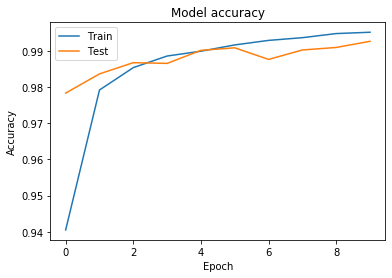

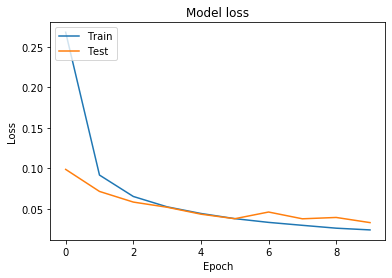

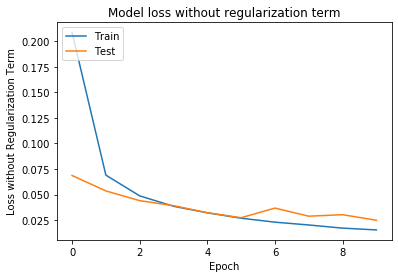

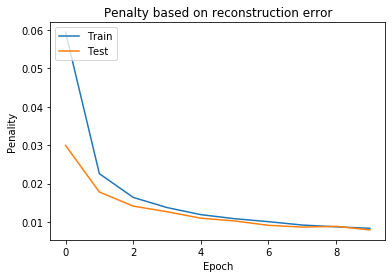

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png');
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss.png');
plt.show()

# Plot training & validation loss without regularization term
plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_categorical_crossentropy'])
plt.title('Model loss without regularization term')
plt.ylabel('Loss without Regularization Term')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss-without-regularization.png');
plt.show()

# Plot reconstruction error
plt.plot(np.array(history.history['loss'])-np.array(history.history['categorical_crossentropy']))
plt.plot(np.array(history.history['val_loss'])-np.array(history.history['val_categorical_crossentropy']))
plt.title('Penalty based on reconstruction error')
plt.ylabel('Penality')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('regularization.png');
plt.show()



In [22]:
#### Alternative Version without regularization ####

In [24]:
#### No regularization
Amodel = tf.keras.Sequential();
Amodel.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=input_shape));
Amodel.add(tf.keras.layers.AveragePooling2D((2,2)));
Amodel.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same',activation='relu'));
Amodel.add(TensorProjectionLayer(9, 9,16, regularization=False));
Amodel.add(tf.keras.layers.Flatten())
Amodel.add(tf.keras.layers.Dense(160, activation='relu'))
Amodel.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
Amodel.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

Ahistory = Amodel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test));
Ascore = Amodel.evaluate(x_test, y_test, verbose=0);
print('Test loss:', Ascore[0]);
print('Test accuracy:', Ascore[1]);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 34s 575us/sample - loss: 0.1912 - accuracy: 0.9413 - val_loss: 0.0626 - val_accuracy: 0.9802
Epoch 2/10
60000/60000 [==============================] - 33s 555us/sample - loss: 0.0595 - accuracy: 0.9823 - val_loss: 0.0398 - val_accuracy: 0.9869
Epoch 3/10
60000/60000 [==============================] - 33s 552us/sample - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.0335 - val_accuracy: 0.9898
Epoch 4/10
60000/60000 [==============================] - 33s 545us/sample - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.0298 - val_accuracy: 0.9902
Epoch 5/10
60000/60000 [==============================] - 33s 547us/sample - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 6/10
60000/60000 [==============================] - 33s 550us/sample - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0267 - val_accuracy: 0.9908
Epoch 7/10
60000/60000 [====================

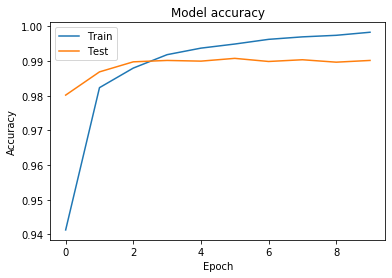

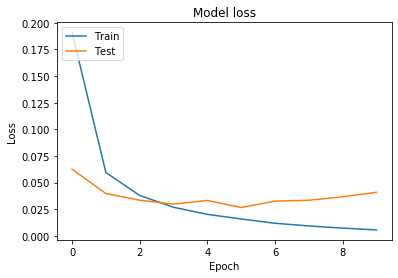

In [25]:
# Plot training & validation accuracy values
plt.plot(Ahistory.history['accuracy'])
plt.plot(Ahistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png');
plt.show()

# Plot training & validation loss values
plt.plot(Ahistory.history['loss'])
plt.plot(Ahistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss.png');
plt.show()
